
# Mini-project 2023

The objective of this project is to clean a large quantity of corneal cell images, and then detect aggregates within them, in order to perform analyses on these aggregates to identify their area, perimeter, etc.

To achieve this, I will first clean all the images, and then utilize the model developed by Meta: Segment Anything Model. This model will allow me to identify the aggregates and extract their metrics.

Ultimately, the idea is to generate and to plot some graphs to classify the aggregates based on these metrics (area, perimeter, etc.) and thereby study their distribution according to these various criteria.

> Note : I chose to work within a Google Colab environment because it enables me to get a better performance than when working locally, especially while working with the SAM model. 


# I- Cleaning
Here, the methodology is straightforward: since the images are divided into two highly distinct halves with very different lighting levels, I will begin by smoothing the lighting using a mask on all the images.

## A- Initializing the coding environment

### 1- Useful libraries

In [ ]:
import imageio.v2 as img #Reading images 
import matplotlib.pyplot as plt  # Display images
import os #accessing system files, etc.
import sys
from skimage import exposure  # Adjust contrast of images
import numpy as np  # Array manipulation
import pickle #storing and loading python variables from files
import gc #garbage collector -> freeing RAM easily

In [ ]:
import imageio.v2 as img #Reading images 
#import matplotlib.pyplot as plt  # Display images
import os #accessing system files, etc.
import sys
#from skimage import exposure  # Adjust contrast of images
import numpy as np  # Array manipulation
import pickle #storing and loading python variables from files
import gc #garbage collector -> freeing RAM easily

### 2- Google Drive
I imported the images of the mini-project on my google drive so that I could use them directly from Colab. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
repo = "/content/drive/MyDrive/Projet_TB1/images" #will be useful to loop over the files later on.
%cd /content/drive/MyDrive/Projet_TB1/images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projet_TB1/images


Let's try and read our first image :

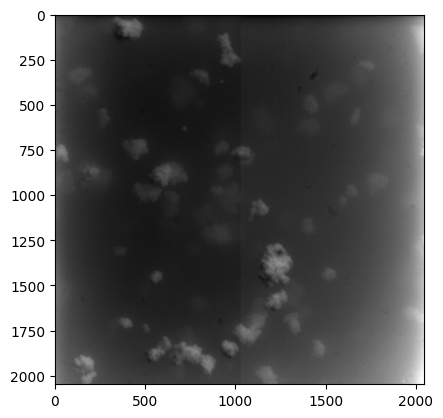

In [ ]:
first = img.imread("Exp2_3h.77vms9sv.000000-0.0000..jpg")
plt.imshow(first)

## B- Masking
As we can see with this in the first image, the images we have to process are pretty dirty, and the light is not homogoneous between their right part and their left part. In order to optimize my analysis, I will first apply a mask to uniformize the light over all the images. 

As a mask, we'll just compute the mean value of each pixel of all images. 

Here we go ! The computation takes me about 2min :

This won't work. Here is a better version :

In [ ]:
repo = '/content/drive/MyDrive/Projet_TB1/images'
mask = None
n = 0
# iterate over files in that directory
for filename in os.listdir(repo): #takes about 2min
    image_i = plt.imread(os.path.join(repo, filename))
    if mask is None:
        mask = np.zeros_like(image_i, dtype=np.float32) #else it is of type uint8 which doesn't support numbers > 255
    mask += image_i
    n += 1

mask /= n # divide by the number of images


Even within Google Collab, this computation is pretty heavy (a bit less than 2min). Therefore, let's store the mask object so I just have to load it when I work on the project :

In [ ]:
with open('../mask.pkl', 'wb') as m:  #Let's write it but not in the images folder
    pickle.dump(mask, m)

Now we won't have to compute it anymore :)

In [ ]:
with open('../mask.pkl', 'rb') as m:  
    mask = pickle.load(m)

Let's visualize our mask and try it on our first image !

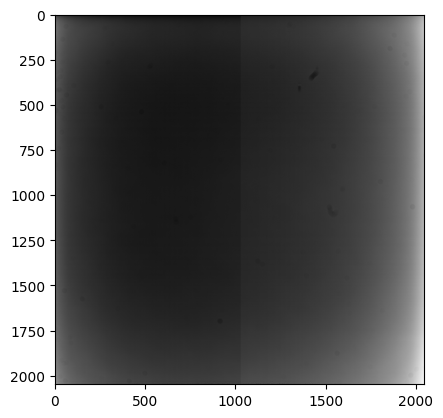

In [ ]:
plt.imshow(np.round(mask).astype(np.uint8)) #for plt.imshow to work)
plt.show()

To apply our mask, we need two steps :
- substracting the mask to the image
- transform the result to fit in [0; 255]

In [ ]:
masked_first = first.astype(np.float32) - mask
masked_first -= masked_first.min()  #to get values between 0 and max + |min|
masked_first *= 255/masked_first.max() #to get values between 0 and 255

Let's visualize our new image ! 

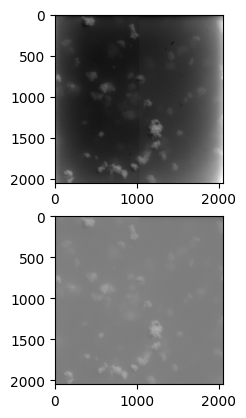

In [ ]:
plt.subplot(2, 1, 1)
plt.imshow(first)
plt.subplot(2, 1, 2)
plt.imshow(np.round(masked_first).astype(np.uint8))
plt.show()

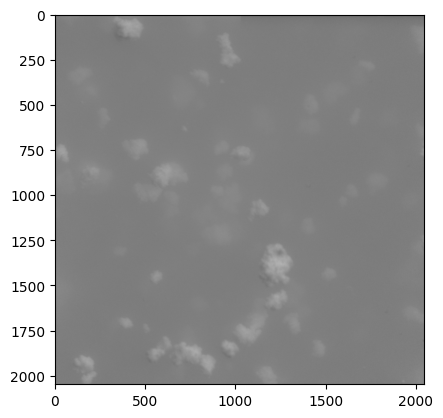

In [ ]:
plt.imshow(masked_first.astype(np.uint8)) #well np.round is unecessary

Alright, I'm pretty happy with the mask. Let's clean our images now. 

# III - Getting those images cleaned

We have achieved a pretty cool mask that enables more or less uniform treatment on our picture. Let's just transform all our images with this mask. This might be pretty heavy, so let's begin with only ten pictures maybe. 

First, let's define clean functions.

> The masking function : It will enable us to mask one image

In [ ]:
def sub_masker(image, mask) :
    image = image.astype(np.float32) - mask
    image -= image.min()  #to get values between 0 and max + |min|
    image *= 255/image.max() #to get values between 0 and 255
    return image
    

> The group masking function :
It will enable us to construct plenty of masked images at once

In [ ]:
def big_masker(images, mask, N) :
    """
    This function returns the first N images of the images array after the action of a substractive mask.
    Note that the output will be of type float, so not directly plotable.
    """
    i = 0
    masked = []
    if N > len(images) :
        for img_i in images :
          i+=1
          masked.append(sub_masker(img_i, mask))
          print(i) #debugging
    else :
        for img_i in images[:N] :
          i+=1
          print(i) #debugging
          masked.append(sub_masker(img_i, mask))
    return masked

Let's try it :

- Gathering some images

In [ ]:
print(repo) #making sure to be in the right place...

/content/drive/MyDrive/Projet_TB1/images


In [ ]:
images = []
i = 1
for filename in os.listdir(repo):
    if(i > 100) : break #Avoiding too many images... Takes less than 4 seconds for 50 / 5000 -> no limit
    if "Exp2" in filename : #avoiding unwanted files -> bugs
      images.append(img.imread(os.path.join(repo, filename))) #path.join -> independence from OS !
      i += 1

In [ ]:
#Piece of code RAM pb -> four times 100 images : 
images = []
i = 1
for filename in os.listdir(repo):
  i+=1
  if((i >= 300) and (i <= 400)) : 
    if "Exp2" in filename : #avoiding unwanted files -> bugs
      images.append(img.imread(os.path.join(repo, filename))) #path.join -> independence from OS !


> Problem when loading the images : Actually, I exceed my free colab RAM after loading exactly 823 images (approximately 1min35 of execution time). I could have chosen to load the images "chunk by chunk" and then reunite them. But since 400 images seems more than enough for the analysis, I simply chose to work with less pictures, avoidoing any RAM problem ! This takes around 50s and 6.4GB of RAM

This kind of heavy operations made me want to work on a Google colab instance instead of my own... It's way quicker in Colab

In [ ]:
len(images)

101

In [ ]:
!pwd

/content/drive/MyDrive/Projet_TB1/images


Same thing as before : let's store those images. This operation can last more than 2min30 for 400 images. There are ways to optimize it but it feels OK for my usage. 

In [ ]:
with open('../images300_400.pkl', 'wb') as m:  #Let's write it but not in the images folder
    pickle.dump(images, m)

And let's retrieve them when needed:

In [ ]:
with open('../images0_99.pkl', 'rb') as m:  
    images = pickle.load(m)

- Unit masking

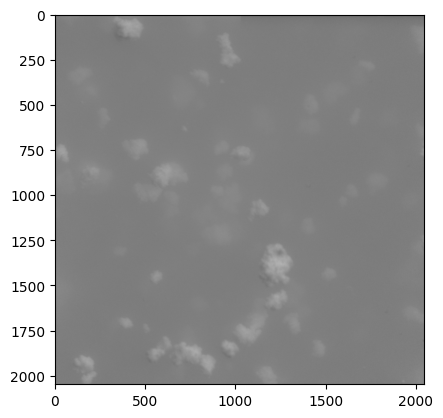

In [ ]:
plt.imshow(sub_masker(first, mask).astype(np.uint8))

It works ! 
- And now the big masker :

In [ ]:
masked_images = big_masker(images, mask, 5)

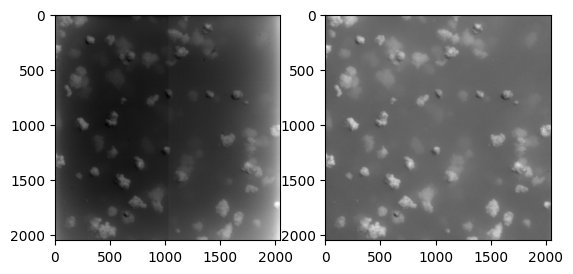

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(images[0].astype(np.uint8))
plt.subplot(1, 2, 2)
plt.imshow(masked_images[0].astype(np.uint8))
plt.show()

Nice ! It seems that we are ready to perform further aggregate detections. Let's begin with a little SAM test. SAM is an machine learning model trained by **Meta** to **"Segment Anything"**. Well let's see if its tittle is deserved. 

# IV-  Let's write the new images

Let's write a little script to export our transformed images. I decided to work with 400 images as I mentionned before. 

## 1- From the files directly


In [ ]:
directory = '/content/drive/MyDrive/Projet_TB1/images'
im = []
i = 1
n_im = 800
for filename in os.listdir(directory):
    if(i > n_im) : #Avoiding too many images... Takes less than 4 seconds for 50 
        break
    im.append(img.imread(os.path.join(directory, filename))) #path.join -> independence from OS !
    i += 1
tf_im = big_masker(im, mask, 100)

<ipython-input-15-02a19cb98db6>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im.append(img.imread(os.path.join(directory, filename))) #path.join -> independence from OS !


## 2- From an array of images

In [ ]:
def big_masker_chunked(images, mask, a = 0, b = len(images)) :
    """
    This function returns the first N images of the images array after the action of a substractive mask.
    Note that the output will be of type float, so not directly plotable.
    """
    i = 0
    masked = []
    for img_i in images[a:b] :
      masked.append(sub_masker(img_i, mask))
    return masked

In [ ]:
tf_im = big_masker(images, mask, 1000) #no need to restrict the number of images since our images object is already at the wanted size. 

On reconstruira chunk par chunk... Problème de RAM

In [ ]:
del mask, images #getting some RAM back before dumping some data
gc.collect()

87

In [ ]:
with open('masked0_99.pkl', 'wb') as m:  
    pickle.dump(tf_im, m)

It works with this strategy !!

In [ ]:
with open('../mask.pkl', 'rb') as m:  
    mask = pickle.load(m)

In [ ]:
with open('../masked0_100.pkl', 'rb') as m:  
    tf_im = pickle.load(m)

In [ ]:
plt.imshow(tf_im[0])

This operation also takes a bit of RAM... I will use a new pickle object to store all we need to execute our code. 

In [ ]:
with open('mask_sub_big_im.pkl', 'wb') as m:  
    pickle.dump([mask, sub_masker, big_masker, tf_im], m)

And here is the checkpoint : 

In [ ]:
with open('mask_sub_big_im.pkl', 'rb') as m:  
    mask, sub_masker, big_masker, tf_im = pickle.load(m)

Here we go ! We now have a checkpoint with all the data we need. 

# V- SAM : Segment Anything (Meta)

To avoid any RAM problem, I chose to work with 100 images. It wouldn't be much complicated to work with 200 or 300 images but I don't think that it adds that much to the work (in terms of difficulty at least). 

Now that we can get clean images, let's see how well the SAM model from meta works to detect agregate on those clean images. 

To begin with, one must install `segment-anything` : `pip install git+https://github.com/facebookresearch/segment-anything.git`.

Let's set up our predictor. 

**Getting our masked images**. This takes a bit less than 1 minute for 100 images. The `pickle` library doesn't seem to be really efficient...

In [12]:
import matplotlib.pyplot as plt  # Display images
import os #accessing system files, etc.
import sys
import numpy as np  # Array manipulation
import pickle #storing and loading python variables from files
import gc #garbage collector -> freeing RAM easily

In [13]:
from google.colab import drive
drive.mount('/content/drive')
repo = "/content/drive/MyDrive/Projet_TB1/images" #will be useful to loop over the files later on.
%cd /content/drive/MyDrive/Projet_TB1/images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projet_TB1/images


In [14]:
with open('../masked0_99.pkl', 'rb') as m:  
    tf_im = pickle.load(m)

Let's divide our data in two equal parts. Else it takes too much RAM to compute all masks. 

In [ ]:
masked0_49 = masked_im[0:50]
masked50_99 = masked_im[50:100]
len(masked0_49) + len(masked50_99)

100

In [ ]:
#Doesn't take too much time actually ( 49s for both)! `pickle` is really bad just for big files
with open('../masked0_49.pkl', 'wb') as m:  
    pickle.dump(masked0_49, m)

with open('../masked50_99.pkl', 'wb') as m:  
    pickle.dump(masked50_99, m)

Alright now we'll do with one half at a time :

In [ ]:
with open('../masked0_49.pkl', 'rb') as m:  
    tf_im = pickle.load(m)

In [15]:
!pip install git+https://github.com/facebookresearch/segment-anything.git # 21s for both operations
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7o5idwwo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7o5idwwo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam_checkpoint = "/content/drive/MyDrive/Projet_TB1/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

And let's try it over our images : 

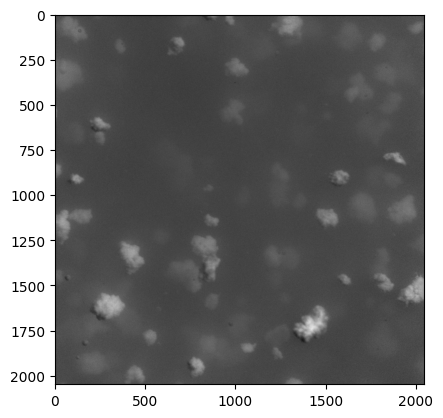

In [ ]:
plt.imshow(masked_im[1].astype(np.uint8))

Let's simplify our work

In [17]:
tf_im  = [item.astype(np.uint8) for item in tf_im]

In [ ]:
tf_im

Now let's do our first try : 

In [ ]:
testim = tf_im[0]
masks = mask_generator.generate(testim)

In [ ]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 14736,
 'bbox': [1453, 1675, 127, 168],
 'predicted_iou': 0.9933980703353882,
 'point_coords': [[1504.0, 1760.0]],
 'stability_score': 0.9868571758270264,
 'crop_box': [0, 0, 2048, 2048]}

Let's try to visualize the result : 

In [ ]:
def show_anns(anns): #This function is defined by Meta in their demo. 
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

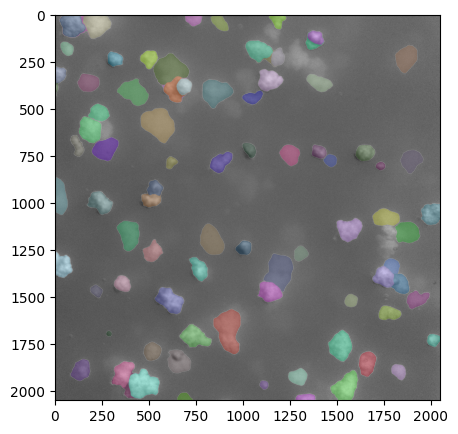

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(testim)
show_anns(masks)
plt.show()

Yes, it is clearly powerful enough for our needs.

# Experimentation on SAM
Here I tested the different SAM models to ensure that the model I was using wasn't too bad compared to the other ones (Meta grants access to various models, more or less heavy). 

In [ ]:
#Little model
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generatorL = SamAutomaticMaskGenerator(sam)

1.4s of execution vs 20s for the other model...

In [ ]:
masksL = mask_generatorL.generate(testim)

It took 3min10 for the model to compute the masks. It was almost 5 minutes for the big model. It's better but it is still very slow... Let's visualize the result anyway. 

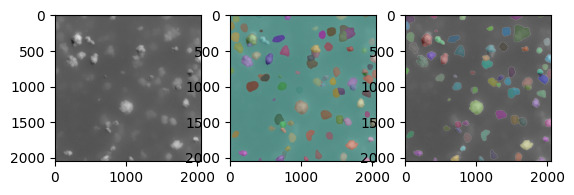

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(testim)

plt.subplot(1, 3, 2)
plt.imshow(testim)
show_anns(masks)

plt.subplot(1, 3, 3)
plt.imshow(testim)
show_anns(masksL)

plt.show()

Well, the big model detects many more segments, but the little model feels OK. Anyway, let's generate our 20 masks. 

# Final computations

SAM will enable us to get the number of aggregates per image and the area of each one of these aggregates. To get an estimation of the perimeter of each aggregate, I'll use the `bbox` key from the mask objects. Indeed, it tells the coordinates of the smallest rectangle containing each aggregate. It is clearly not as good as having the perimeter, but in our case, computing the perimeter of this rectangle will give us a good idea of the repartition of aggregate perimeters. 

## Constructing the nb_particles array, the areas array and the perimeters array
Well, let's gather the data we need to plot some graphs. 

### 1- nb_particles

In [18]:
SAM_masks = [mask_generator.generate(item) for item in tf_im] # 2min for 100 images

In [19]:
with open('../sam_masks.pkl', 'wb') as m :
  pickle.dump(SAM_masks, m)

In [ ]:
nb_particles = [len(item) for item in SAM_img] #nb of masks per image

In [ ]:
nb_particles

## 2- areas

In [ ]:
areas = []
for img in SAM_img :
  for mask in img : 
    areas.append(mask['area'])

In [ ]:
len(areas)

7679

## 3- perimeters
The boundary box of the mask is given in XYWH format. Then, the quantity 2*W + 2*H is the perimeter of the boundary box.  

In [ ]:
SAM_img[0][0]['bbox']

[1453, 1675, 127, 168]

In [ ]:
perimeters = []
for img in SAM_img : 
  for mask in img :
    perimeters.append(2 * mask['bbox'][2] + mask['bbox'][3])

In [ ]:
len(perimeters)

7679

# Final plots
Well, let's plot our plots... 

## Repartition of number of aggregates per image
The title of the plot is pretty explicit. 


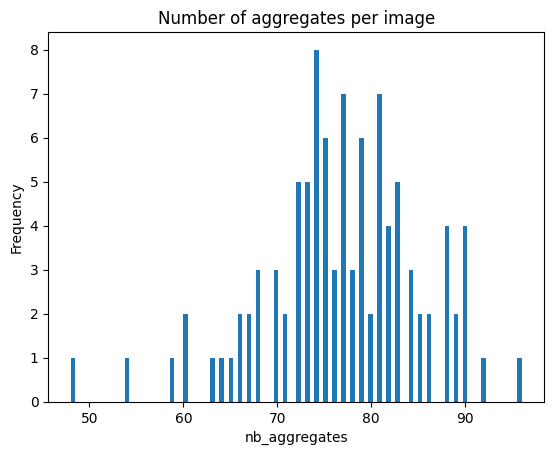

In [ ]:
num_bins = len(nb_particles)

# Create the histogram
plt.hist(nb_particles, bins=num_bins)
plt.xlabel('nb_aggregates')
plt.ylabel('Frequency')
plt.title("Number of aggregates per image")
plt.show()

In [ ]:
print(np.std(nb_particles), np.mean(nb_particles))

8.30216236892534 76.79


## Repartition of areas of aggregates 

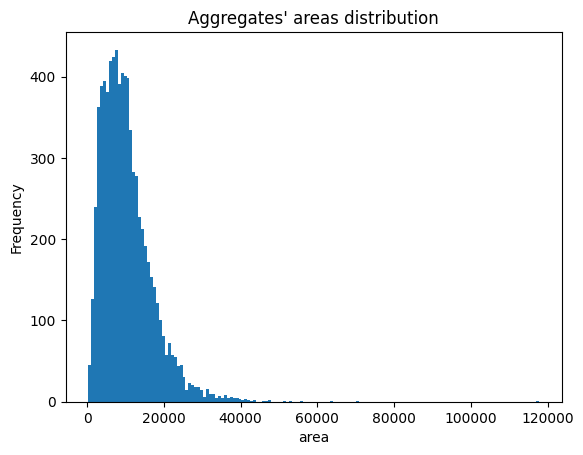

In [ ]:
num_bins = len(areas) // 50 #1 bin = represents approximately 50 aggregates (mean)

# Create the histogram
plt.hist(areas, bins=num_bins)
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title("Aggregates' areas distribution")
plt.show()

There are many outliers with really big areas. This is pretty interesting since a doctor might want to get a closer look at outliers !

## 3- perimeters

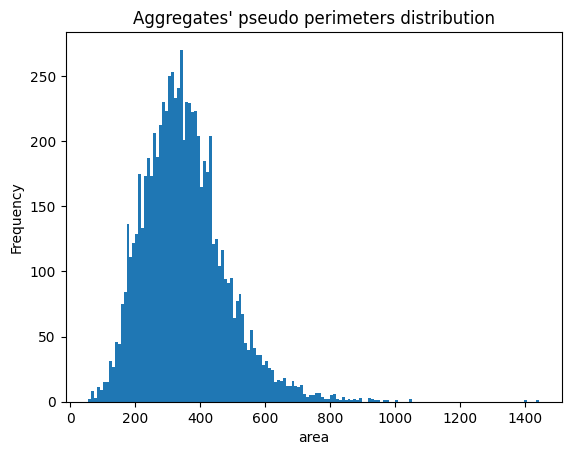

In [ ]:
num_bins = len(perimeters) // 50 

# Create the histogram
plt.hist(perimeters, bins=num_bins)
plt.xlabel('perimeters')
plt.ylabel('Frequency')
plt.title("Aggregates' pseudo perimeters distribution")
plt.show()

There seems to be less outliers when we consider the bbox perimeter ! It might be more interesting to study the areas to detect hostile aggregates.